# <center> Kaggle Competition Assignment <center> Ian Brandenburg (2304791) <center> [GitHub Repo](https://github.com/Iandrewburg/Data_Science/tree/main/Data_Science_2/Assignments/Take_Home_Final)
    
    
The Kaggle competition has been launched, please register using this [link](https://www.kaggle.com/t/f79b637ede074e70a233661b4614083c).

You will find the training and test data in the data section of the competition, along with a description of the features. You will need to build models on the training data and make predictions on the test data and submit your solutions to Kaggle. You will also find a sample solution file in the data section that shows the format you will need to use for your own submissions.

The deadline for Kaggle solutions is 8PM on 19 April. You will be graded primarily on the basis of your work and how clearly you explain your methods and results. Those in the top three in the competition will receive some extra points. I expect you to experiment with all the methods we have covered: linear models, random forest, gradient boosting, neural networks + parameter tuning, feature engineering.

You will see the public score of your best model on the leaderboard. A private dataset will be used to evaluate the final performance of your model to avoid overfitting based on the leaderboard.

You should also submit to Moodle the documentation (ipynb and pdf) of your work, including exploratory data analysis, data cleaning, parameter tuning and evaluation. Aim for concise explanations.

### Import Libraries
---

In [1]:
# General utilities
import numpy as np
import pandas as pd
import time
import os
import warnings
from itertools import combinations

# Sklearn model selection, preprocessing, metrics, and ensemble methods
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Sklearn pipeline utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# XGBoost
import xgboost as xgb

# Cat Boost Classifier
from catboost import CatBoostClassifier

# Light GBM
import lightgbm as lgb

# InterpretML for explainable boosting
from interpret.glassbox import ExplainableBoostingClassifier

# TensorFlow and Keras for neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings('ignore')


# Data Wrangling
---

## Data Import
---

In [2]:
train_data = pd.read_csv("https://raw.githubusercontent.com/Iandrewburg/Data_Science/main/Data_Science_2/Assignments/Take_Home_Final/train.csv")
train_data.head()


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0,7


In [3]:
test_data = pd.read_csv("https://raw.githubusercontent.com/Iandrewburg/Data_Science/main/Data_Science_2/Assignments/Take_Home_Final/test.csv")
test_data.head()


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,article_id
0,134,11,217,0.631579,1.0,0.818966,4,2,2,0,...,0.136364,0.5,-0.170370,-0.200000,-0.155556,0.288889,-0.155556,0.211111,0.155556,2
1,415,11,1041,0.489423,1.0,0.700321,22,3,0,14,...,0.050000,1.0,-0.426268,-1.000000,-0.100000,0.975000,0.300000,0.475000,0.300000,4
2,625,9,486,0.599585,1.0,0.727273,4,3,1,0,...,0.062500,0.7,-0.387821,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000,10
3,148,14,505,0.509018,1.0,0.718861,8,4,1,1,...,0.100000,1.0,-0.284722,-0.400000,-0.050000,0.000000,0.000000,0.500000,0.000000,13
4,294,14,274,0.620301,1.0,0.726190,5,1,1,0,...,0.100000,0.6,-0.333333,-0.333333,-0.333333,0.000000,0.000000,0.500000,0.000000,26


In [4]:
test_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

## Exploratory Data Analysis
---

### Variable Descriptions
---


    timedelta: Days between the article publication and the dataset acquisition (non-predictive)
    n_tokens_title: Number of words in the title
    n_tokens_content: Number of words in the content
    n_unique_tokens: Rate of unique words in the content
    n_non_stop_words: Rate of non-stop words in the content
    n_non_stop_unique_tokens: Rate of unique non-stop words in the content
    num_hrefs: Number of links
    num_self_hrefs: Number of links to other articles published by Mashable
    num_imgs: Number of images
    num_videos: Number of videos
    average_token_length: Average length of the words in the content
    num_keywords: Number of keywords in the metadata
    data_channel_is_lifestyle: Is data channel 'Lifestyle'?
    data_channel_is_entertainment: Is data channel 'Entertainment'?
    data_channel_is_bus: Is data channel 'Business'?
    data_channel_is_socmed: Is data channel 'Social Media'?
    data_channel_is_tech: Is data channel 'Tech'?
    data_channel_is_world: Is data channel 'World'?
    kw_min_min: Worst keyword (min. shares)
    kw_max_min: Worst keyword (max. shares)
    kw_avg_min: Worst keyword (avg. shares)
    kw_min_max: Best keyword (min. shares)
    kw_max_max: Best keyword (max. shares)
    kw_avg_max: Best keyword (avg. shares)
    kw_min_avg: Avg. keyword (min. shares)
    kw_max_avg: Avg. keyword (max. shares)
    kw_avg_avg: Avg. keyword (avg. shares)
    self_reference_min_shares: Min. shares of referenced articles in Mashable
    self_reference_max_shares: Max. shares of referenced articles in Mashable
    self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
    weekday_is_monday: Was the article published on a Monday?
    weekday_is_tuesday: Was the article published on a Tuesday?
    weekday_is_wednesday: Was the article published on a Wednesday?
    weekday_is_thursday: Was the article published on a Thursday?
    weekday_is_friday: Was the article published on a Friday?
    weekday_is_saturday: Was the article published on a Saturday?
    weekday_is_sunday: Was the article published on a Sunday?
    is_weekend: Was the article published on the weekend?
    LDA_00: Closeness to LDA topic 0
    LDA_01: Closeness to LDA topic 1
    LDA_02: Closeness to LDA topic 2
    LDA_03: Closeness to LDA topic 3
    LDA_04: Closeness to LDA topic 4
    global_subjectivity: Text subjectivity
    global_sentiment_polarity: Text sentiment polarity
    global_rate_positive_words: Rate of positive words in the content
    global_rate_negative_words: Rate of negative words in the content
    rate_positive_words: Rate of positive words among non-neutral tokens
    rate_negative_words: Rate of negative words among non-neutral tokens
    avg_positive_polarity: Avg. polarity of positive words
    min_positive_polarity: Min. polarity of positive words
    max_positive_polarity: Max. polarity of positive words
    avg_negative_polarity: Avg. polarity of negative words
    min_negative_polarity: Min. polarity of negative words
    max_negative_polarity: Max. polarity of negative words
    title_subjectivity: Title subjectivity
    title_sentiment_polarity: Title polarity
    abs_title_subjectivity: Absolute subjectivity level
    abs_title_sentiment_polarity: Absolute polarity level
    is_popular: Whether or not the article was among the most popular ones based on shares on social media
    article_id: Unique identifier of the article


In [5]:
train_data.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,...,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,355.645646,10.390812,545.008274,0.555076,1.005852,0.695432,10.912690,3.290788,4.524535,1.263546,...,0.757780,-0.259709,-0.520981,-0.107793,0.281878,0.069691,0.341427,0.155234,0.121649,19834.913530
std,214.288261,2.110135,469.358037,4.064572,6.039655,3.768796,11.316508,3.840874,8.213823,4.189080,...,0.247293,0.128488,0.290454,0.095672,0.323461,0.264379,0.188735,0.225066,0.326886,11432.376037
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.471400,1.000000,0.626126,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328704,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,9965.000000
50%,342.000000,10.000000,409.000000,0.539894,1.000000,0.690566,8.000000,2.000000,1.000000,0.000000,...,0.800000,-0.252827,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,0.000000,19859.000000
75%,545.000000,12.000000,712.000000,0.609375,1.000000,0.755208,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186494,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,0.000000,29742.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,74.000000,111.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000,39643.000000


In [6]:
print(f"The shape of the training set is {train_data.shape[0]} rows, and {train_data.shape[1]} columns.") 

The shape of the training set is 29733 rows, and 61 columns.


In [7]:
total_missing_values = train_data.isnull().sum()[train_data.isnull().sum() > 0].sum()
print(f"There are a total of {total_missing_values} missing values in the dataset.")


There are a total of 0 missing values in the dataset.


In [8]:
train_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

## Feature Engineering
---

In [9]:
# Defining variable groups
basic_text_features = ['n_tokens_title',
                       'n_tokens_content',
                       'n_unique_tokens',
                       'n_non_stop_words',
                       'n_non_stop_unique_tokens',
                       'average_token_length',
                       'num_keywords']
content_properties = ['num_hrefs',
                      'num_self_hrefs',
                      'num_imgs',
                      'num_videos',
                      'global_subjectivity',
                      'global_sentiment_polarity',
                      'global_rate_positive_words',
                      'global_rate_negative_words']
keyword_performance = ['kw_min_min',
                       'kw_max_min',
                       'kw_avg_min',
                       'kw_min_max',
                       'kw_max_max',
                       'kw_avg_max',
                       'kw_min_avg',
                       'kw_max_avg',
                       'kw_avg_avg']
self_reference_metrics = ['self_reference_min_shares',
                          'self_reference_max_shares',
                          'self_reference_avg_sharess']

# dropped 'weekday_is_monday' and 'is_weekend'
publication_timing = ['weekday_is_tuesday',
                      'weekday_is_wednesday',
                      'weekday_is_thursday',
                      'weekday_is_friday',
                      'weekday_is_saturday',
                      'weekday_is_sunday']

# dropped 'data_channel_is_lifestyle'
content_topic_and_sentiment = ['data_channel_is_entertainment',
                               'data_channel_is_bus',
                               'data_channel_is_socmed',
                               'data_channel_is_tech',
                               'data_channel_is_world',
                               'LDA_00',
                               'LDA_01',
                               'LDA_02',
                               'LDA_03',
                               'LDA_04',
                               'rate_positive_words',
                               'rate_negative_words',
                               'avg_positive_polarity',
                               'min_positive_polarity', 
                               'max_positive_polarity',
                               'avg_negative_polarity',
                               'min_negative_polarity',
                               'max_negative_polarity']
title_sentiment = ['title_subjectivity',
                   'title_sentiment_polarity',
                   'abs_title_subjectivity',
                   'abs_title_sentiment_polarity']


In [10]:
def square_features(variables, df): 
    sqaured_features = []
    for var in variables:
        feature_name = f'{var}_squared'
        df[feature_name] = df[var] ** 2
        sqaured_features.append(feature_name)
    return sqaured_features

def cube_features(variables, df): 
    cubed_features = []
    for var in variables:
        feature_name = f'{var}_cubed'
        df[feature_name] = df[var] ** 3
        cubed_features.append(feature_name)
    return cubed_features
        
def interact_features(variables, df):
    interacted_features = []
    for (var1, var2) in combinations(variables, 2):
        feature_name = f'{var1}_{var2}_interaction'
        df[feature_name] = df[var1] * df[var2]
        interacted_features.append(feature_name)
    return interacted_features

In [11]:
##################SQUARED TERMS###################
# square basic features
sqrd_basic_text_features = square_features(basic_text_features, train_data)
square_features(basic_text_features, test_data)
    
# square title sentiment features
sqrd_title_sentiment = square_features(title_sentiment, train_data)
square_features(title_sentiment, test_data)

# square content properties
sqrd_content_properties = square_features(content_properties, train_data)
square_features(content_properties, test_data)

# square keyword performance
sqrd_keyword_performance = square_features(keyword_performance, train_data)
square_features(keyword_performance, test_data)

# square self reference metrics
sqrd_self_reference_metrics = square_features(self_reference_metrics, train_data)
square_features(self_reference_metrics, test_data)

##################CUBED TERMS###################
# CUBED basic features
cube_basic_text_features = cube_features(basic_text_features, train_data)
cube_features(basic_text_features, test_data)
    
# CUBED title sentiment features
cube_title_sentiment = cube_features(title_sentiment, train_data)
cube_features(title_sentiment, test_data)

# CUBED content properties
cube_content_properties = cube_features(content_properties, train_data)
cube_features(content_properties, test_data)

# CUBED keyword performance
cube_keyword_performance = cube_features(keyword_performance, train_data)
cube_features(keyword_performance, test_data)

# CUBED self reference metrics
cube_self_reference_metrics = cube_features(self_reference_metrics, train_data)
cube_features(self_reference_metrics, test_data)
  
################INTERACTION TERMS##################
# Interacting the basic features
interaction_basic_text_features = interact_features(basic_text_features, train_data)
interact_features(basic_text_features, test_data)

# Interacting the title sentiment features
interaction_title_sentiment = interact_features(title_sentiment, train_data)
interact_features(title_sentiment, test_data)

# Interacting content properties
interaction_content_properties = interact_features(content_properties, train_data)
interact_features(content_properties, test_data)

# Interacting keyword performance
interaction_keyword_performance = interact_features(keyword_performance, train_data)
interact_features(keyword_performance, test_data)

# Interacting self reference metrics
interaction_self_reference_metrics = interact_features(self_reference_metrics, train_data)
interact_features(self_reference_metrics, test_data)


['self_reference_min_shares_self_reference_max_shares_interaction',
 'self_reference_min_shares_self_reference_avg_sharess_interaction',
 'self_reference_max_shares_self_reference_avg_sharess_interaction']

In [12]:
perm_importance_variables = ['n_tokens_title',
                             'n_tokens_content',
                             'n_unique_tokens',
                             'n_non_stop_words',
                             'n_non_stop_unique_tokens',
                             'average_token_length',
                             'num_keywords',
                             'num_hrefs', 
                             'num_self_hrefs', 
                             'num_imgs', 
                             'num_videos', 
                             'global_subjectivity', 
                             'global_sentiment_polarity', 
                             'kw_min_min', 
                             'kw_max_min', 
                             'kw_avg_min', 
                             'kw_min_max', 
                             'kw_max_max',
                             'kw_avg_max', 
                             'kw_min_avg', 
                             'kw_max_avg', 
                             'kw_avg_avg', 
                             'self_reference_min_shares', 
                             'self_reference_max_shares', 
                             'self_reference_avg_sharess',
                             'weekday_is_thursday', 
                             'weekday_is_friday',
                             'weekday_is_sunday', 
                             'data_channel_is_entertainment',
                             'data_channel_is_bus', 
                             'data_channel_is_socmed', 
                             'data_channel_is_tech', 
                             'data_channel_is_world', 
                             'LDA_00', 
                             'LDA_01',
                             'LDA_02', 
                             'LDA_03', 
                             'LDA_04', 
                             'rate_positive_words', 
                             'avg_positive_polarity',
                             'min_positive_polarity', 
                             'avg_negative_polarity', 
                             'min_negative_polarity', 
                             'max_negative_polarity', 
                             'title_subjectivity',
                             'abs_title_subjectivity']


In [13]:
test_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos',
       ...
       'kw_max_max_kw_avg_avg_interaction',
       'kw_avg_max_kw_min_avg_interaction',
       'kw_avg_max_kw_max_avg_interaction',
       'kw_avg_max_kw_avg_avg_interaction',
       'kw_min_avg_kw_max_avg_interaction',
       'kw_min_avg_kw_avg_avg_interaction',
       'kw_max_avg_kw_avg_avg_interaction',
       'self_reference_min_shares_self_reference_max_shares_interaction',
       'self_reference_min_shares_self_reference_avg_sharess_interaction',
       'self_reference_max_shares_self_reference_avg_sharess_interaction'],
      dtype='object', length=216)

In [14]:
# Define models
models = {
    'M1': basic_text_features,
    'M2': basic_text_features + content_properties,
    'M3': basic_text_features + content_properties + keyword_performance,
    'M4': basic_text_features + content_properties + keyword_performance + self_reference_metrics,
    'M5': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing,
    'M6': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment,
    'M7': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment, 
    'M8': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment,
    'M9': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features,
    'M10': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + interaction_basic_text_features,
    'M11': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + interaction_basic_text_features + interaction_title_sentiment,
    'M12': perm_importance_variables,
    'M13': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_content_properties + sqrd_keyword_performance,
    'M14': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties,
    'M15': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance,
    'M16': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance + sqrd_self_reference_metrics,
    'M17': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties,
    'M18': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance,
    'M19': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance + interaction_self_reference_metrics,
    'M20': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance + interaction_self_reference_metrics + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance + sqrd_self_reference_metrics,
    'M21': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_basic_text_features + interaction_title_sentiment + interaction_keyword_performance + interaction_self_reference_metrics + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance + sqrd_self_reference_metrics,
    'M22': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment, 
    'M23': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features, 
    'M24': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties, 
    'M25': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance, 
    'M26': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics, 
    'M27': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics + interaction_content_properties, 
    'M28': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics + interaction_content_properties + interaction_basic_text_features, 
    'M29': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics + interaction_content_properties + interaction_basic_text_features + interaction_title_sentiment, 
    'M30': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics + interaction_content_properties + interaction_basic_text_features + interaction_title_sentiment + interaction_keyword_performance, 
    'M31': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + cube_title_sentiment + sqrd_basic_text_features + cube_basic_text_features + sqrd_content_properties + cube_content_properties + sqrd_keyword_performance + cube_keyword_performance + sqrd_self_reference_metrics + cube_self_reference_metrics + interaction_content_properties + interaction_basic_text_features + interaction_title_sentiment + interaction_keyword_performance + interaction_self_reference_metrics 


}


In [15]:
# Split 'train_data' into training and validation sets
X = train_data.drop(['is_popular', 'timedelta', 'article_id'], axis=1)
y = train_data['is_popular']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20240407)


# Models
---

In [16]:
def calculateRMSLE(prediction, y_obs):
    return round(np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) - 
                np.log(y_obs + 1)
            )**2
        )
    ), 4)

In [17]:
# initilialize results list
results = []

## Logistic Regression
---

### Simple Logistic Regression
---

In [18]:
for model_name, features in models.items():
    # Append "Logistic Regression" to the model name for clarity
    full_model_name = f"{model_name} Logistic Regression"

    # Define steps for pipeline: feature scaling and logistic regression
    steps = [
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("log_reg", LogisticRegression())
    ]

    # Create pipeline
    pipeline = Pipeline(steps)

    # Fit the model on training data
    pipeline.fit(X_train[features], y_train)

    # Predict probabilities on the training and validation data
    # Note: We use predict_proba to get probabilities, and we're interested in the probabilities of the positive class (usually at index 1)
    train_prob = pipeline.predict_proba(X_train[features])[:, 1]
    val_prob = pipeline.predict_proba(X_val[features])[:, 1]

    # Calculate AUC
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    results.append([full_model_name, train_auc, val_auc, train_rmsle, val_rmsle])

results_df = pd.DataFrame(results, columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])

results_df.tail(31)


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
0,M1 Logistic Regression,0.548108,0.555135,0.2271,0.2314
1,M2 Logistic Regression,0.624687,0.627810,0.2253,0.2291
2,M3 Logistic Regression,0.682657,0.686424,0.2225,0.2259
3,M4 Logistic Regression,0.686342,0.688129,0.2224,0.2259
4,M5 Logistic Regression,0.687915,0.684988,0.2223,0.2260
5,M6 Logistic Regression,0.693311,0.694309,0.2220,0.2255
6,M7 Logistic Regression,0.694318,0.695099,0.2219,0.2253
7,M8 Logistic Regression,0.695176,0.696331,0.2219,0.2251
8,M9 Logistic Regression,0.695775,0.694353,0.2218,0.2252
9,M10 Logistic Regression,0.699305,0.693886,0.2216,0.2251


### Tuned Logistic Regression
---

In [19]:
for model_name, features in models.items():

    start_time = time.time()
    # Define steps for pipeline: feature scaling and logistic regression
    steps = [
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("log_reg", LogisticRegression(solver='liblinear'))
    ]

    # Create pipeline
    pipeline = Pipeline(steps)

    # Define a range of inverse regularization strength `C`
    param_grid = {
        'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'log_reg__penalty': ['l2']  # L2 regularization
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train[features], y_train)

    best_model = grid_search.best_estimator_
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    results.append([f"{model_name} Logistic Regression Tuned", train_auc, val_auc, train_rmsle, val_rmsle])
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df = pd.DataFrame(results, columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])

results_df.tail(31)


Completed M1 in 0.98 seconds
Completed M2 in 1.91 seconds
Completed M3 in 4.39 seconds
Completed M4 in 4.96 seconds
Completed M5 in 6.05 seconds
Completed M6 in 10.84 seconds
Completed M7 in 12.25 seconds
Completed M8 in 17.74 seconds
Completed M9 in 25.21 seconds
Completed M10 in 111.26 seconds
Completed M11 in 91.14 seconds
Completed M12 in 8.28 seconds
Completed M13 in 31.09 seconds
Completed M14 in 29.58 seconds
Completed M15 in 45.38 seconds
Completed M16 in 44.61 seconds
Completed M17 in 28.90 seconds
Completed M18 in 73.55 seconds
Completed M19 in 80.24 seconds
Completed M20 in 187.04 seconds
Completed M21 in 341.66 seconds
Completed M22 in 22.43 seconds
Completed M23 in 37.47 seconds
Completed M24 in 60.85 seconds
Completed M25 in 88.07 seconds
Completed M26 in 106.10 seconds
Completed M27 in 141.23 seconds
Completed M28 in 263.02 seconds
Completed M29 in 358.95 seconds
Completed M30 in 408.96 seconds
Completed M31 in 436.17 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
31,M1 Logistic Regression Tuned,0.578511,0.597577,0.2267,0.2305
32,M2 Logistic Regression Tuned,0.625409,0.628886,0.2388,0.2415
33,M3 Logistic Regression Tuned,0.683566,0.687520,0.2225,0.2259
34,M4 Logistic Regression Tuned,0.686853,0.688830,0.2224,0.2259
35,M5 Logistic Regression Tuned,0.688710,0.686084,0.2223,0.2260
36,M6 Logistic Regression Tuned,0.693308,0.694601,0.2221,0.2255
37,M7 Logistic Regression Tuned,0.694352,0.695420,0.2220,0.2253
38,M8 Logistic Regression Tuned,0.695495,0.696638,0.2219,0.2251
39,M9 Logistic Regression Tuned,0.695925,0.695024,0.2219,0.2253
40,M10 Logistic Regression Tuned,0.699440,0.694135,0.2216,0.2251


## Lasso Model
---

In [20]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer

    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("lasso", LassoCV())
    ]
    pipe_lasso = Pipeline(steps)
    pipe_lasso.fit(X_train[features], y_train)

    train_scores = pipe_lasso.predict(X_train[features])
    val_scores = pipe_lasso.predict(X_val[features])

    # Convert scores to binary predictions based on the median threshold
    threshold = np.median(train_scores)
    train_pred = np.where(train_scores > threshold, 1, 0)
    val_pred = np.where(val_scores > threshold, 1, 0)

    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_pred)
    val_auc = roc_auc_score(y_val, val_pred)
    
    train_rmsle = calculateRMSLE(train_pred, y_train) 
    val_rmsle = calculateRMSLE(val_pred, y_val)

    new_row = pd.DataFrame([[f"{group_name} Lasso", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 0.29 seconds
Completed M2 in 0.29 seconds
Completed M3 in 0.35 seconds
Completed M4 in 0.40 seconds
Completed M5 in 0.41 seconds
Completed M6 in 1.13 seconds
Completed M7 in 1.11 seconds
Completed M8 in 1.14 seconds
Completed M9 in 1.28 seconds
Completed M10 in 1.97 seconds
Completed M11 in 2.08 seconds
Completed M12 in 0.87 seconds
Completed M13 in 1.56 seconds
Completed M14 in 1.33 seconds
Completed M15 in 1.60 seconds
Completed M16 in 1.27 seconds
Completed M17 in 1.46 seconds
Completed M18 in 2.36 seconds
Completed M19 in 2.14 seconds
Completed M20 in 3.06 seconds
Completed M21 in 3.99 seconds
Completed M22 in 1.40 seconds
Completed M23 in 1.46 seconds
Completed M24 in 1.82 seconds
Completed M25 in 2.70 seconds
Completed M26 in 2.95 seconds
Completed M27 in 3.77 seconds
Completed M28 in 4.38 seconds
Completed M29 in 4.61 seconds
Completed M30 in 5.34 seconds
Completed M31 in 5.89 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
62,M1 Lasso,0.523024,0.531205,0.4853,0.4840
63,M2 Lasso,0.589911,0.592422,0.4711,0.4696
64,M3 Lasso,0.629210,0.625074,0.4625,0.4643
65,M4 Lasso,0.631790,0.629762,0.4620,0.4616
66,M5 Lasso,0.635561,0.631840,0.4611,0.4617
67,M6 Lasso,0.642905,0.646199,0.4595,0.4580
68,M7 Lasso,0.641516,0.654014,0.4598,0.4550
69,M8 Lasso,0.642905,0.649153,0.4595,0.4568
70,M9 Lasso,0.642508,0.644775,0.4596,0.4582
71,M10 Lasso,0.644294,0.643148,0.4592,0.4592


## Stacking Model
---

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Define your base models
base_models = [
    ('dt', DecisionTreeClassifier(random_state=20240407)),
    ('rf', RandomForestClassifier(random_state=20240407)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=20240407))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

for model_name, features in models.items():
    start_time = time.time()  # Start timer
    
    # Create a pipeline with scaling and stacking model
    pipeline = Pipeline([
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("stacking", stacking_model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train[features], y_train)
    
    # Predict probabilities on the training and validation data
    train_prob = pipeline.predict_proba(X_train[features])[:, 1]
    val_prob = pipeline.predict_proba(X_val[features])[:, 1]
    
    # Calculate AUC
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    # Append results
    new_row = pd.DataFrame([[f"{model_name} STACKED", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")


results_df.tail(31)


Completed M1 in 27.42 seconds
Completed M2 in 37.75 seconds
Completed M3 in 47.45 seconds
Completed M4 in 56.97 seconds
Completed M5 in 49.07 seconds
Completed M6 in 68.92 seconds
Completed M7 in 67.88 seconds
Completed M8 in 66.06 seconds
Completed M9 in 76.81 seconds
Completed M10 in 104.90 seconds
Completed M11 in 104.74 seconds
Completed M12 in 59.84 seconds
Completed M13 in 82.94 seconds
Completed M14 in 80.55 seconds
Completed M15 in 92.28 seconds
Completed M16 in 92.47 seconds
Completed M17 in 103.85 seconds
Completed M18 in 149.08 seconds
Completed M19 in 158.47 seconds
Completed M20 in 174.34 seconds
Completed M21 in 197.28 seconds
Completed M22 in 65.26 seconds
Completed M23 in 76.45 seconds
Completed M24 in 91.53 seconds
Completed M25 in 106.27 seconds
Completed M26 in 108.24 seconds
Completed M27 in 143.81 seconds
Completed M28 in 438.40 seconds
Completed M29 in 171.27 seconds
Completed M30 in 205.02 seconds
Completed M31 in 206.20 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
93,M1 STACKED,0.999279,0.582803,0.1769,0.2308
94,M2 STACKED,0.999535,0.647539,0.1329,0.2291
95,M3 STACKED,1.000000,0.694660,0.0860,0.2254
96,M4 STACKED,1.000000,0.701611,0.0851,0.2257
97,M5 STACKED,1.000000,0.704613,0.0814,0.2256
98,M6 STACKED,1.000000,0.714806,0.0774,0.2253
99,M7 STACKED,1.000000,0.715391,0.0787,0.2244
100,M8 STACKED,1.000000,0.716757,0.0797,0.2244
101,M9 STACKED,1.000000,0.712760,0.0766,0.2252
102,M10 STACKED,1.000000,0.710793,0.0816,0.2249


## Decision Tree Classifier
---

### Decision Tree Classifer Max Depth 5

In [22]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=5, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD5", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 0.10 seconds
Completed M2 in 0.18 seconds
Completed M3 in 0.27 seconds
Completed M4 in 0.27 seconds
Completed M5 in 0.29 seconds
Completed M6 in 0.42 seconds
Completed M7 in 0.45 seconds
Completed M8 in 0.46 seconds
Completed M9 in 0.53 seconds
Completed M10 in 0.78 seconds
Completed M11 in 0.81 seconds
Completed M12 in 0.40 seconds
Completed M13 in 0.63 seconds
Completed M14 in 0.61 seconds
Completed M15 in 0.70 seconds
Completed M16 in 0.73 seconds
Completed M17 in 0.79 seconds
Completed M18 in 1.35 seconds
Completed M19 in 1.36 seconds
Completed M20 in 1.65 seconds
Completed M21 in 1.86 seconds
Completed M22 in 0.49 seconds
Completed M23 in 0.60 seconds
Completed M24 in 0.75 seconds
Completed M25 in 0.94 seconds
Completed M26 in 0.97 seconds
Completed M27 in 1.32 seconds
Completed M28 in 1.58 seconds
Completed M29 in 1.61 seconds
Completed M30 in 2.09 seconds
Completed M31 in 2.20 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
124,M1 Decision Tree MD5,0.593985,0.579518,0.2254,0.2309
125,M2 Decision Tree MD5,0.645188,0.613544,0.2229,0.2310
126,M3 Decision Tree MD5,0.689169,0.681748,0.2207,0.2274
127,M4 Decision Tree MD5,0.702222,0.677891,0.2197,0.2263
128,M5 Decision Tree MD5,0.702322,0.675899,0.2197,0.2265
129,M6 Decision Tree MD5,0.701975,0.673412,0.2197,0.2268
130,M7 Decision Tree MD5,0.702134,0.669154,0.2197,0.2275
131,M8 Decision Tree MD5,0.702134,0.668961,0.2197,0.2277
132,M9 Decision Tree MD5,0.702134,0.669002,0.2197,0.2275
133,M10 Decision Tree MD5,0.699318,0.672435,0.2196,0.2274


### Decision Tree Classifer Max Depth 6
---

In [23]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=6, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD6", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 0.10 seconds
Completed M2 in 0.20 seconds
Completed M3 in 0.32 seconds
Completed M4 in 0.34 seconds
Completed M5 in 0.34 seconds
Completed M6 in 0.52 seconds
Completed M7 in 0.53 seconds
Completed M8 in 0.55 seconds
Completed M9 in 0.61 seconds
Completed M10 in 0.92 seconds
Completed M11 in 0.97 seconds
Completed M12 in 0.46 seconds
Completed M13 in 0.72 seconds
Completed M14 in 0.70 seconds
Completed M15 in 0.82 seconds
Completed M16 in 0.85 seconds
Completed M17 in 0.92 seconds
Completed M18 in 1.51 seconds
Completed M19 in 1.50 seconds
Completed M20 in 1.92 seconds
Completed M21 in 2.26 seconds
Completed M22 in 0.62 seconds
Completed M23 in 0.70 seconds
Completed M24 in 0.88 seconds
Completed M25 in 1.09 seconds
Completed M26 in 1.15 seconds
Completed M27 in 1.54 seconds
Completed M28 in 1.85 seconds
Completed M29 in 1.88 seconds
Completed M30 in 2.42 seconds
Completed M31 in 2.58 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
155,M1 Decision Tree MD6,0.606142,0.563066,0.2242,0.2322
156,M2 Decision Tree MD6,0.659318,0.615339,0.2211,0.2326
157,M3 Decision Tree MD6,0.702358,0.683364,0.2188,0.2288
158,M4 Decision Tree MD6,0.715865,0.669937,0.2173,0.2285
159,M5 Decision Tree MD6,0.716589,0.672902,0.2173,0.2283
160,M6 Decision Tree MD6,0.717090,0.670325,0.2172,0.2282
161,M7 Decision Tree MD6,0.717947,0.666980,0.2174,0.2286
162,M8 Decision Tree MD6,0.717947,0.666980,0.2174,0.2286
163,M9 Decision Tree MD6,0.717947,0.666983,0.2174,0.2286
164,M10 Decision Tree MD6,0.711630,0.673889,0.2175,0.2285


### Decision Tree Classifer Max Depth 7
---

In [24]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=7, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD7", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 0.12 seconds
Completed M2 in 0.21 seconds
Completed M3 in 0.36 seconds
Completed M4 in 0.39 seconds
Completed M5 in 0.39 seconds
Completed M6 in 0.59 seconds
Completed M7 in 0.59 seconds
Completed M8 in 0.64 seconds
Completed M9 in 0.70 seconds
Completed M10 in 1.05 seconds
Completed M11 in 1.10 seconds
Completed M12 in 0.53 seconds
Completed M13 in 0.83 seconds
Completed M14 in 0.81 seconds
Completed M15 in 0.93 seconds
Completed M16 in 0.97 seconds
Completed M17 in 1.05 seconds
Completed M18 in 1.67 seconds
Completed M19 in 1.76 seconds
Completed M20 in 2.17 seconds
Completed M21 in 2.49 seconds
Completed M22 in 0.65 seconds
Completed M23 in 0.79 seconds
Completed M24 in 1.01 seconds
Completed M25 in 1.26 seconds
Completed M26 in 1.33 seconds
Completed M27 in 1.76 seconds
Completed M28 in 2.10 seconds
Completed M29 in 2.25 seconds
Completed M30 in 2.96 seconds
Completed M31 in 2.91 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
186,M1 Decision Tree MD7,0.618633,0.574762,0.2229,0.2334
187,M2 Decision Tree MD7,0.676916,0.621189,0.2183,0.2361
188,M3 Decision Tree MD7,0.716705,0.679916,0.2162,0.2296
189,M4 Decision Tree MD7,0.731960,0.658502,0.2138,0.2317
190,M5 Decision Tree MD7,0.732297,0.660033,0.2137,0.2325
191,M6 Decision Tree MD7,0.732842,0.668368,0.2138,0.2314
192,M7 Decision Tree MD7,0.734117,0.666903,0.2140,0.2311
193,M8 Decision Tree MD7,0.734678,0.667129,0.2139,0.2310
194,M9 Decision Tree MD7,0.734117,0.665766,0.2140,0.2312
195,M10 Decision Tree MD7,0.726670,0.676924,0.2143,0.2302


### Decision Tree Classifer Grid Search
---

In [25]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    # Define the steps of the pipeline
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)
    
    # Define the parameter grid to search over
    param_grid = {
        "tree__max_depth": range(3, 9) 
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class with the best model
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_depth = best_model.named_steps['tree'].max_depth
    new_row = pd.DataFrame([[f"{group_name} Decision Tree Grid Search", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best max_depth={best_depth} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 with best max_depth=7 in 5.48 seconds
Completed M2 with best max_depth=5 in 1.02 seconds
Completed M3 with best max_depth=4 in 1.30 seconds
Completed M4 with best max_depth=5 in 1.51 seconds
Completed M5 with best max_depth=5 in 1.57 seconds
Completed M6 with best max_depth=4 in 2.19 seconds
Completed M7 with best max_depth=4 in 2.31 seconds
Completed M8 with best max_depth=4 in 2.44 seconds
Completed M9 with best max_depth=4 in 2.69 seconds
Completed M10 with best max_depth=5 in 4.27 seconds
Completed M11 with best max_depth=5 in 4.52 seconds
Completed M12 with best max_depth=4 in 2.01 seconds
Completed M13 with best max_depth=4 in 3.25 seconds
Completed M14 with best max_depth=4 in 3.17 seconds
Completed M15 with best max_depth=4 in 3.55 seconds
Completed M16 with best max_depth=4 in 3.77 seconds
Completed M17 with best max_depth=3 in 3.89 seconds
Completed M18 with best max_depth=5 in 6.64 seconds
Completed M19 with best max_depth=3 in 6.39 seconds
Completed M20 with be

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
217,M1 Decision Tree Grid Search,0.618633,0.574762,0.2229,0.2334
218,M2 Decision Tree Grid Search,0.645188,0.613544,0.2229,0.2310
219,M3 Decision Tree Grid Search,0.677494,0.677595,0.2219,0.2268
220,M4 Decision Tree Grid Search,0.702222,0.677891,0.2197,0.2263
221,M5 Decision Tree Grid Search,0.702322,0.675899,0.2197,0.2265
222,M6 Decision Tree Grid Search,0.688481,0.671874,0.2212,0.2271
223,M7 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
224,M8 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
225,M9 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
226,M10 Decision Tree Grid Search,0.699318,0.672435,0.2196,0.2274


## Random Forest
---

In [26]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("random_forest", RandomForestClassifier(random_state=20240407))
    ]
    pipe_rf = Pipeline(steps)
    
    # Define the parameter grid to search over
    param_grid = {
        "random_forest__max_depth": [None, 3, 5, 7],  # None means no limit on the depth
        "random_forest__n_estimators": [10, 50, 100],  # Number of trees
        "random_forest__min_samples_split": [2, 4]  # Minimum number of samples required to split an internal node
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class with the best model
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_params = grid_search.best_params_
    new_row = pd.DataFrame([[f"{group_name} Random Forest", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best parameters {best_params} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 17.49 seconds
Completed M2 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 4, 'random_forest__n_estimators': 100} in 23.53 seconds
Completed M3 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 31.09 seconds
Completed M4 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 36.96 seconds
Completed M5 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 32.57 seconds
Completed M6 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 43.04 seconds
Completed M7 with best parameters {'random_forest__m

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
248,M1 Random Forest,0.692130,0.603921,0.2215,0.2301
249,M2 Random Forest,0.733817,0.656886,0.2172,0.2279
250,M3 Random Forest,0.774158,0.708519,0.2132,0.2241
251,M4 Random Forest,0.782287,0.711795,0.2109,0.2241
252,M5 Random Forest,0.781630,0.712681,0.2114,0.2242
253,M6 Random Forest,0.792354,0.714636,0.2109,0.2240
254,M7 Random Forest,0.792197,0.715297,0.2110,0.2240
255,M8 Random Forest,0.791399,0.713278,0.2111,0.2241
256,M9 Random Forest,0.795269,0.714616,0.2106,0.2240
257,M10 Random Forest,0.795790,0.715590,0.2104,0.2239


## Gradient Boosted Random Forest
---

In [27]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("xgb", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]
    pipe_xgb = Pipeline(steps)
    
    # Define the parameter grid
    param_grid = {
        "xgb__n_estimators": [100, 200],  # Number of trees
        "xgb__max_depth": [3, 5, 7],  # Depth of trees
        "xgb__learning_rate": [0.01, 0.1]  # Step size shrinkage used in update to prevents overfitting
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on the training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_params = grid_search.best_params_
    new_row = pd.DataFrame([[f"{group_name} XGBoost", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best parameters {best_params} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 with best parameters {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200} in 3.63 seconds
Completed M2 with best parameters {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200} in 6.17 seconds
Completed M3 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 9.08 seconds
Completed M4 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 10.31 seconds
Completed M5 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 10.84 seconds
Completed M6 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 16.22 seconds
Completed M7 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 16.97 seconds
Completed M8 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 17.61 s

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
279,M1 XGBoost,0.665216,0.596593,0.2241,0.2309
280,M2 XGBoost,0.719108,0.659764,0.2198,0.2287
281,M3 XGBoost,0.747470,0.712439,0.2162,0.2243
282,M4 XGBoost,0.759199,0.716104,0.2146,0.2243
283,M5 XGBoost,0.759368,0.716645,0.2145,0.2242
284,M6 XGBoost,0.768038,0.720897,0.2138,0.2241
285,M7 XGBoost,0.769562,0.719086,0.2135,0.2242
286,M8 XGBoost,0.769562,0.719086,0.2135,0.2242
287,M9 XGBoost,0.769550,0.719653,0.2135,0.2241
288,M10 XGBoost,0.771894,0.722050,0.2131,0.2235


## Light Gradient Boosting Model
---

### Simple Light Gradient Boosting
---

In [28]:
for group_name, features in models.items():
    start_time = time.time()

    # Create datasets for LightGBM
    lgb_train = lgb.Dataset(X_train[features], label=y_train)
    lgb_val = lgb.Dataset(X_val[features], label=y_val, reference=lgb_train)

    # Simplify params by only setting the essentials
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'random_state': 20240325
    }

    # Train model with a fixed number of boost rounds to simplify
    num_boost_round = 100
    lgb_model = lgb.train(params,
                          lgb_train,
                          num_boost_round=num_boost_round,
                          valid_sets=[lgb_val])

    # Prediction and evaluation
    train_prob = lgb_model.predict(X_train[features], num_iteration=lgb_model.best_iteration)
    val_prob = lgb_model.predict(X_val[features], num_iteration=lgb_model.best_iteration)

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Assuming calculateRMSLE is previously defined
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} LightGBM Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 0.61 seconds
Completed M2 in 0.52 seconds
Completed M3 in 0.56 seconds
Completed M4 in 0.56 seconds
Completed M5 in 0.57 seconds
Completed M6 in 0.64 seconds
Completed M7 in 0.65 seconds
Completed M8 in 0.68 seconds
Completed M9 in 0.71 seconds
Completed M10 in 0.79 seconds
Completed M11 in 0.83 seconds
Completed M12 in 0.63 seconds
Completed M13 in 0.77 seconds
Completed M14 in 0.89 seconds
Completed M15 in 0.91 seconds
Completed M16 in 0.93 seconds
Completed M17 in 0.91 seconds
Completed M18 in 1.13 seconds
Completed M19 in 1.19 seconds
Completed M20 in 1.16 seconds
Completed M21 in 1.45 seconds
Completed M22 in 0.70 seconds
Completed M23 in 0.74 seconds
Completed M24 in 0.82 seconds
Completed M25 in 0.91 seconds
Completed M26 in 0.92 seconds
Completed M27 in 1.05 seconds
Completed M28 in 1.16 seconds
Completed M29 in 1.26 seconds
Completed M30 in 1.70 seconds
Completed M31 in 1.73 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
310,M1 LightGBM Simple,0.842516,0.591113,0.2070,0.2311
311,M2 LightGBM Simple,0.892884,0.641908,0.1952,0.2294
312,M3 LightGBM Simple,0.916443,0.703488,0.1869,0.2251
313,M4 LightGBM Simple,0.919905,0.706887,0.1838,0.2259
314,M5 LightGBM Simple,0.915052,0.706785,0.1845,0.2261
315,M6 LightGBM Simple,0.933078,0.711330,0.1802,0.2251
316,M7 LightGBM Simple,0.937193,0.708391,0.1791,0.2256
317,M8 LightGBM Simple,0.937193,0.708391,0.1791,0.2256
318,M9 LightGBM Simple,0.937193,0.708391,0.1791,0.2256
319,M10 LightGBM Simple,0.937184,0.709963,0.1774,0.2247


### Tuned Light Gradient Boosting
---

In [29]:
for group_name, features in models.items():
    start_time = time.time()

    # Create datasets for LightGBM
    lgb_train = lgb.Dataset(X_train[features], label=y_train)
    lgb_val = lgb.Dataset(X_val[features], label=y_val, reference=lgb_train)

    # Adjust parameters to reduce overfitting
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,  # Lowered learning rate
        'num_leaves': 20,  # Fewer leaves
        'lambda_l1': 0.5,  # Added L1 regularization
        'lambda_l2': 0.5,  # Added L2 regularization
        'verbose': -1,
        'random_state': 20240325
    }

    # Train model with early stopping
    lgb_model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_val],
                          num_boost_round=1000)  # Maximum number of boosting rounds

    # Prediction and evaluation
    train_prob = lgb_model.predict(X_train[features], num_iteration=lgb_model.best_iteration)
    val_prob = lgb_model.predict(X_val[features], num_iteration=lgb_model.best_iteration)

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Assuming calculateRMSLE is previously defined
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} LightGBM Tuned", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")


results_df.tail(31)

Completed M1 in 4.61 seconds
Completed M2 in 4.71 seconds
Completed M3 in 5.20 seconds
Completed M4 in 5.47 seconds
Completed M5 in 5.12 seconds
Completed M6 in 5.75 seconds
Completed M7 in 5.78 seconds
Completed M8 in 5.53 seconds
Completed M9 in 6.23 seconds
Completed M10 in 6.44 seconds
Completed M11 in 6.64 seconds
Completed M12 in 5.80 seconds
Completed M13 in 5.84 seconds
Completed M14 in 6.34 seconds
Completed M15 in 6.39 seconds
Completed M16 in 6.19 seconds
Completed M17 in 6.95 seconds
Completed M18 in 7.29 seconds
Completed M19 in 8.21 seconds
Completed M20 in 8.21 seconds
Completed M21 in 9.86 seconds
Completed M22 in 5.72 seconds
Completed M23 in 6.60 seconds
Completed M24 in 6.39 seconds
Completed M25 in 7.16 seconds
Completed M26 in 7.77 seconds
Completed M27 in 8.05 seconds
Completed M28 in 8.98 seconds
Completed M29 in 9.13 seconds
Completed M30 in 9.72 seconds
Completed M31 in 10.65 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
341,M1 LightGBM Tuned,0.939188,0.573151,0.1857,0.2336
342,M2 LightGBM Tuned,0.976504,0.618826,0.1605,0.2321
343,M3 LightGBM Tuned,0.989452,0.687944,0.1446,0.2273
344,M4 LightGBM Tuned,0.989442,0.699864,0.1414,0.2273
345,M5 LightGBM Tuned,0.991744,0.698887,0.1390,0.2274
346,M6 LightGBM Tuned,0.995478,0.706937,0.1317,0.2261
347,M7 LightGBM Tuned,0.996543,0.703983,0.1292,0.2265
348,M8 LightGBM Tuned,0.996543,0.703983,0.1292,0.2265
349,M9 LightGBM Tuned,0.996543,0.703983,0.1292,0.2265
350,M10 LightGBM Tuned,0.997476,0.704864,0.1250,0.2257


## Cat Boosting
---

### Simple Cat Boost

In [30]:
for group_name, features in models.items():
    start_time = time.time()

    # Defining CatBoost model
    cb_model = CatBoostClassifier(
        iterations=500,  # Fewer iterations for quicker learning
        learning_rate=0.01,  # Higher learning rate for faster convergence
        depth=4,  # Lower depth to reduce model complexity and overfitting
        random_state=20240325,
        verbose=False  # Silence the output to avoid flooding the notebook/console
    )
    
    # Fit the model
    cb_model.fit(X_train[features], y_train, eval_set=(X_val[features], y_val), early_stopping_rounds=50, verbose=False)

    # Predict and evaluate
    train_prob = cb_model.predict_proba(X_train[features])[:, 1]
    val_prob = cb_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Assuming calculateRMSLE is defined elsewhere
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} CatBoost Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 3.44 seconds
Completed M2 in 3.24 seconds
Completed M3 in 3.49 seconds
Completed M4 in 3.48 seconds
Completed M5 in 3.20 seconds
Completed M6 in 3.46 seconds
Completed M7 in 3.58 seconds
Completed M8 in 3.90 seconds
Completed M9 in 3.89 seconds
Completed M10 in 4.02 seconds
Completed M11 in 4.21 seconds
Completed M12 in 3.77 seconds
Completed M13 in 3.98 seconds
Completed M14 in 3.76 seconds
Completed M15 in 4.07 seconds
Completed M16 in 4.36 seconds
Completed M17 in 4.11 seconds
Completed M18 in 4.50 seconds
Completed M19 in 4.69 seconds
Completed M20 in 5.43 seconds
Completed M21 in 5.57 seconds
Completed M22 in 3.73 seconds
Completed M23 in 4.11 seconds
Completed M24 in 4.22 seconds
Completed M25 in 4.32 seconds
Completed M26 in 4.60 seconds
Completed M27 in 5.31 seconds
Completed M28 in 5.18 seconds
Completed M29 in 5.47 seconds
Completed M30 in 6.38 seconds
Completed M31 in 5.87 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
372,M1 CatBoost Simple,0.618453,0.595543,0.2255,0.2303
373,M2 CatBoost Simple,0.669739,0.656781,0.2227,0.2279
374,M3 CatBoost Simple,0.707846,0.708040,0.2203,0.2244
375,M4 CatBoost Simple,0.720150,0.714292,0.2191,0.2240
376,M5 CatBoost Simple,0.720699,0.713801,0.2191,0.2241
377,M6 CatBoost Simple,0.723002,0.715514,0.2190,0.2239
378,M7 CatBoost Simple,0.723666,0.717000,0.2189,0.2238
379,M8 CatBoost Simple,0.723455,0.716248,0.2189,0.2239
380,M9 CatBoost Simple,0.723954,0.717557,0.2188,0.2238
381,M10 CatBoost Simple,0.723738,0.715799,0.2189,0.2239


### Tuned Cat Boost

In [31]:
for group_name, features in models.items():
    start_time = time.time()

    cb_model = CatBoostClassifier(
        iterations=2000,  # Explore more iterations for deeper learning
        learning_rate=0.001,  # Further reduce learning rate for more gradual learning
        depth=7,  # Slightly increase depth for capturing more complex patterns
        l2_leaf_reg=5,  # Increase L2 regularization to control overfit depth's complexity
        bagging_temperature=1,  # Introduce bagging for randomness, reducing overfitting
        early_stopping_rounds=100,
        random_state=20240325,
        verbose=False)  # Use only a portion of data for each tree, increasing diversity
    
    cb_model.fit(X_train[features], y_train, eval_set=(X_val[features], y_val), early_stopping_rounds=50, verbose=False)

    train_prob = cb_model.predict_proba(X_train[features])[:, 1]
    val_prob = cb_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)


    new_row = pd.DataFrame([[f"{group_name} CatBoost Tuned", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 16.63 seconds
Completed M2 in 17.90 seconds
Completed M3 in 20.68 seconds
Completed M4 in 21.23 seconds
Completed M5 in 21.07 seconds
Completed M6 in 24.97 seconds
Completed M7 in 26.55 seconds
Completed M8 in 27.29 seconds
Completed M9 in 29.09 seconds
Completed M10 in 33.91 seconds
Completed M11 in 35.61 seconds
Completed M12 in 24.77 seconds
Completed M13 in 30.18 seconds
Completed M14 in 30.29 seconds
Completed M15 in 32.84 seconds
Completed M16 in 32.79 seconds
Completed M17 in 34.28 seconds
Completed M18 in 45.00 seconds
Completed M19 in 45.59 seconds
Completed M20 in 52.07 seconds
Completed M21 in 58.94 seconds
Completed M22 in 28.65 seconds
Completed M23 in 30.82 seconds
Completed M24 in 34.09 seconds
Completed M25 in 38.57 seconds
Completed M26 in 39.91 seconds
Completed M27 in 47.98 seconds
Completed M28 in 53.11 seconds
Completed M29 in 55.45 seconds
Completed M30 in 66.49 seconds
Completed M31 in 66.22 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
403,M1 CatBoost Tuned,0.626457,0.593662,0.2306,0.2349
404,M2 CatBoost Tuned,0.682740,0.655602,0.2274,0.2324
405,M3 CatBoost Tuned,0.716299,0.704937,0.2244,0.2287
406,M4 CatBoost Tuned,0.728570,0.711844,0.2229,0.2280
407,M5 CatBoost Tuned,0.729916,0.711713,0.2228,0.2280
408,M6 CatBoost Tuned,0.734208,0.712797,0.2226,0.2280
409,M7 CatBoost Tuned,0.736047,0.712959,0.2225,0.2280
410,M8 CatBoost Tuned,0.736876,0.713473,0.2224,0.2280
411,M9 CatBoost Tuned,0.736553,0.713060,0.2225,0.2280
412,M10 CatBoost Tuned,0.736948,0.713204,0.2224,0.2280


## Explainable Boosting Machine
---

### Simple EBM

In [32]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start

    # Adjusted EBM pipeline without SimpleImputer for numerical data
    ebm = ExplainableBoostingClassifier(random_state=20240325)

    ebm.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = ebm.predict_proba(X_train[features])[:, 1]
    val_prob = ebm.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} EBM", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 7.88 seconds
Completed M2 in 5.56 seconds
Completed M3 in 8.20 seconds
Completed M4 in 8.54 seconds
Completed M5 in 10.48 seconds
Completed M6 in 16.10 seconds
Completed M7 in 17.86 seconds
Completed M8 in 18.70 seconds
Completed M9 in 22.03 seconds
Completed M10 in 29.12 seconds
Completed M11 in 32.21 seconds
Completed M12 in 15.36 seconds
Completed M13 in 23.41 seconds
Completed M14 in 23.31 seconds
Completed M15 in 27.13 seconds
Completed M16 in 28.41 seconds
Completed M17 in 28.71 seconds
Completed M18 in 45.57 seconds
Completed M19 in 46.40 seconds
Completed M20 in 58.07 seconds
Completed M21 in 71.17 seconds
Completed M22 in 20.55 seconds
Completed M23 in 24.68 seconds
Completed M24 in 30.64 seconds
Completed M25 in 37.38 seconds
Completed M26 in 38.50 seconds
Completed M27 in 51.10 seconds
Completed M28 in 60.19 seconds
Completed M29 in 62.76 seconds
Completed M30 in 80.82 seconds
Completed M31 in 82.06 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
434,M1 EBM,0.628037,0.599450,0.2246,0.2300
435,M2 EBM,0.687042,0.658695,0.2211,0.2276
436,M3 EBM,0.727854,0.710408,0.2182,0.2242
437,M4 EBM,0.743061,0.718112,0.2165,0.2240
438,M5 EBM,0.744391,0.718935,0.2165,0.2239
439,M6 EBM,0.761945,0.724416,0.2143,0.2235
440,M7 EBM,0.765401,0.727386,0.2137,0.2232
441,M8 EBM,0.766168,0.726259,0.2137,0.2233
442,M9 EBM,0.762717,0.728033,0.2141,0.2232
443,M10 EBM,0.766798,0.726993,0.2136,0.2231


### **Permutation Importance**

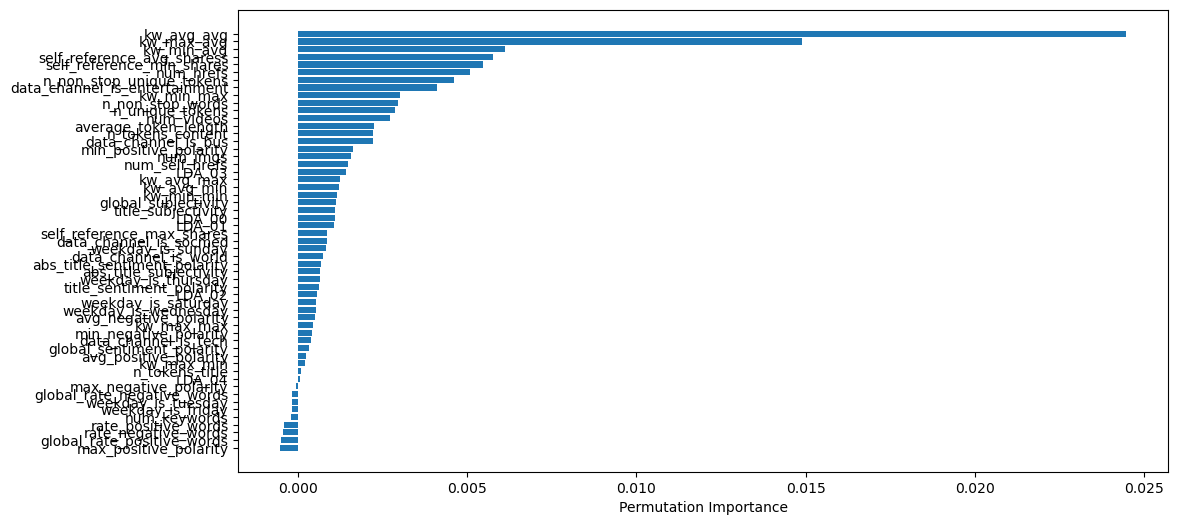

In [33]:
# Choose a model (for example, M1 EBM) and its features for illustration
ebm = ExplainableBoostingClassifier(random_state=20240325)
ebm.fit(X_train[models['M7']], y_train)

# Compute permutation-based feature importance
perm_importance = permutation_importance(ebm, X_val[models['M7']], y_val, n_repeats=10, random_state=42, scoring='roc_auc')

# Retrieve and display feature importances
feature_names = np.array(models['M7'])
sorted_idx = perm_importance.importances_mean.argsort()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()


In [34]:
# Assuming perm_importance is calculated as shown previously
feature_names = np.array(models['M7'])  # Adjust to use the correct model features as needed

# Identify features with positive permutation importance values
positive_importance_features = feature_names[perm_importance.importances_mean > 0]

# Print out the feature names
print("Features with positive permutation importance:")
for feature in positive_importance_features:
    print(feature)

# Create a variable group with these features
perm_importance_positive = positive_importance_features.tolist()

print("Variable group with positive permutation importance:")
print(perm_importance_positive)


Features with positive permutation importance:
n_tokens_title
n_tokens_content
n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens
average_token_length
num_hrefs
num_self_hrefs
num_imgs
num_videos
global_subjectivity
global_sentiment_polarity
kw_min_min
kw_max_min
kw_avg_min
kw_min_max
kw_max_max
kw_avg_max
kw_min_avg
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
weekday_is_wednesday
weekday_is_thursday
weekday_is_saturday
weekday_is_sunday
data_channel_is_entertainment
data_channel_is_bus
data_channel_is_socmed
data_channel_is_tech
data_channel_is_world
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04
avg_positive_polarity
min_positive_polarity
avg_negative_polarity
min_negative_polarity
title_subjectivity
title_sentiment_polarity
abs_title_subjectivity
abs_title_sentiment_polarity
Variable group with positive permutation importance:
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 

### Adjusted EBM 1
---

In [35]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start

    # Adjusted EBM pipeline without SimpleImputer for numerical data
    ebm_adjusted = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.01,
        max_bins=256,
        interactions=10,
        early_stopping_rounds=50
    )

    ebm_adjusted.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = ebm_adjusted.predict_proba(X_train[features])[:, 1]
    val_prob = ebm_adjusted.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} EBM Adjusted 1", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 3.86 seconds
Completed M2 in 4.43 seconds
Completed M3 in 5.70 seconds
Completed M4 in 6.81 seconds
Completed M5 in 6.95 seconds
Completed M6 in 12.10 seconds
Completed M7 in 12.17 seconds
Completed M8 in 12.84 seconds
Completed M9 in 13.69 seconds
Completed M10 in 19.48 seconds
Completed M11 in 19.88 seconds
Completed M12 in 10.35 seconds
Completed M13 in 15.02 seconds
Completed M14 in 15.56 seconds
Completed M15 in 17.55 seconds
Completed M16 in 18.07 seconds
Completed M17 in 18.12 seconds
Completed M18 in 27.47 seconds
Completed M19 in 27.29 seconds
Completed M20 in 34.66 seconds
Completed M21 in 42.02 seconds
Completed M22 in 13.70 seconds
Completed M23 in 16.18 seconds
Completed M24 in 19.84 seconds
Completed M25 in 24.07 seconds
Completed M26 in 24.39 seconds
Completed M27 in 32.04 seconds
Completed M28 in 37.78 seconds
Completed M29 in 38.65 seconds
Completed M30 in 49.82 seconds
Completed M31 in 51.07 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
465,M1 EBM Adjusted 1,0.636023,0.607193,0.2242,0.2297
466,M2 EBM Adjusted 1,0.678342,0.658737,0.2218,0.2277
467,M3 EBM Adjusted 1,0.718354,0.709401,0.2193,0.2243
468,M4 EBM Adjusted 1,0.728440,0.718318,0.2185,0.2239
469,M5 EBM Adjusted 1,0.729174,0.719371,0.2184,0.2238
470,M6 EBM Adjusted 1,0.741476,0.724784,0.2172,0.2235
471,M7 EBM Adjusted 1,0.742880,0.725028,0.2170,0.2233
472,M8 EBM Adjusted 1,0.743572,0.725698,0.2169,0.2233
473,M9 EBM Adjusted 1,0.738593,0.726296,0.2175,0.2232
474,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231


### Adjusted EBM 2
---

In [36]:
for group_name, features in models.items():
    start_time = time.time()

    ebm_more_adjusted = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.005,  # Slightly lower learning rate for more fine-grained adjustments
        max_bins=512,  # Increased number of bins for potentially capturing more detail
        interactions=15,  # Allowing for more interactions
        early_stopping_rounds=100,  # More patience on early stopping to allow more rounds for convergence
        n_jobs=-1  # Utilize all CPU cores for faster training
    )

    ebm_more_adjusted.fit(X_train[features], y_train)

    train_prob = ebm_more_adjusted.predict_proba(X_train[features])[:, 1]
    val_prob = ebm_more_adjusted.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    new_row = pd.DataFrame([[f"{group_name} EBM Adjusted 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 7.39 seconds
Completed M2 in 7.72 seconds
Completed M3 in 9.87 seconds
Completed M4 in 10.86 seconds
Completed M5 in 11.57 seconds
Completed M6 in 17.13 seconds
Completed M7 in 18.03 seconds
Completed M8 in 19.27 seconds
Completed M9 in 21.18 seconds
Completed M10 in 27.25 seconds
Completed M11 in 29.29 seconds
Completed M12 in 15.10 seconds
Completed M13 in 22.38 seconds
Completed M14 in 23.96 seconds
Completed M15 in 25.75 seconds
Completed M16 in 26.29 seconds
Completed M17 in 26.70 seconds
Completed M18 in 42.31 seconds
Completed M19 in 42.00 seconds
Completed M20 in 51.85 seconds
Completed M21 in 62.51 seconds
Completed M22 in 20.08 seconds
Completed M23 in 23.93 seconds
Completed M24 in 28.01 seconds
Completed M25 in 33.66 seconds
Completed M26 in 35.50 seconds
Completed M27 in 44.24 seconds
Completed M28 in 53.32 seconds
Completed M29 in 55.19 seconds
Completed M30 in 73.72 seconds
Completed M31 in 73.84 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
496,M1 EBM Adjusted 2,0.640790,0.604144,0.2240,0.2297
497,M2 EBM Adjusted 2,0.685208,0.658450,0.2213,0.2277
498,M3 EBM Adjusted 2,0.725316,0.712219,0.2187,0.2240
499,M4 EBM Adjusted 2,0.735612,0.719000,0.2175,0.2238
500,M5 EBM Adjusted 2,0.736297,0.719678,0.2176,0.2237
501,M6 EBM Adjusted 2,0.745007,0.722964,0.2167,0.2235
502,M7 EBM Adjusted 2,0.746603,0.725448,0.2165,0.2233
503,M8 EBM Adjusted 2,0.746996,0.725894,0.2164,0.2233
504,M9 EBM Adjusted 2,0.743411,0.725140,0.2170,0.2233
505,M10 EBM Adjusted 2,0.740707,0.724105,0.2173,0.2233


## Neural Network Models
---

In [37]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

n_features = X_train.shape[1]
    
# Reshape your data accordingly
X_train_reshaped = X_train_scaled.reshape((-1, n_features, 1)) 
X_val_reshaped = X_val_scaled.reshape((-1, n_features, 1))

### Simple Neural Network Model 1
---

In [38]:
for model_name, features in models.items():
    start_time = time.time()  # Timer start
    
    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)

Completed M1 in 7.06 seconds
Completed M2 in 8.11 seconds
Completed M3 in 7.84 seconds
Completed M4 in 6.69 seconds
Completed M5 in 8.90 seconds
Completed M6 in 7.41 seconds
Completed M7 in 7.84 seconds
Completed M8 in 7.43 seconds
Completed M9 in 7.79 seconds
Completed M10 in 6.70 seconds
Completed M11 in 9.24 seconds
Completed M12 in 8.11 seconds
Completed M13 in 6.24 seconds
Completed M14 in 8.25 seconds
Completed M15 in 6.54 seconds
Completed M16 in 8.50 seconds
Completed M17 in 6.86 seconds
Completed M18 in 4.98 seconds
Completed M19 in 4.65 seconds
Completed M20 in 6.30 seconds
Completed M21 in 5.61 seconds
Completed M22 in 6.75 seconds
Completed M23 in 5.55 seconds
Completed M24 in 9.07 seconds
Completed M25 in 10.98 seconds
Completed M26 in 8.35 seconds
Completed M27 in 8.71 seconds
Completed M28 in 8.41 seconds
Completed M29 in 9.44 seconds
Completed M30 in 6.08 seconds
Completed M31 in 5.09 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
527,M31 NN Simple,0.741335,0.697379,0.2166,0.223
528,M31 NN Simple,0.762277,0.697792,0.2166,0.223
529,M31 NN Simple,0.763364,0.697828,0.2166,0.223
530,M31 NN Simple,0.748440,0.696561,0.2166,0.223
531,M31 NN Simple,0.763079,0.701149,0.2166,0.223
532,M31 NN Simple,0.759928,0.701576,0.2166,0.223
533,M31 NN Simple,0.753629,0.691433,0.2166,0.223
534,M31 NN Simple,0.759079,0.703278,0.2166,0.223
535,M31 NN Simple,0.756915,0.699650,0.2166,0.223
536,M31 NN Simple,0.747009,0.702391,0.2166,0.223


### Simple Neural Network Model 2
---

In [39]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Simple 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 21.17 seconds
Completed M2 in 14.99 seconds
Completed M3 in 19.28 seconds
Completed M4 in 28.84 seconds
Completed M5 in 16.66 seconds
Completed M6 in 22.48 seconds
Completed M7 in 20.77 seconds
Completed M8 in 13.06 seconds
Completed M9 in 10.00 seconds
Completed M10 in 16.34 seconds
Completed M11 in 15.49 seconds
Completed M12 in 21.39 seconds
Completed M13 in 22.12 seconds
Completed M14 in 14.68 seconds
Completed M15 in 15.50 seconds
Completed M16 in 13.02 seconds
Completed M17 in 16.72 seconds
Completed M18 in 14.25 seconds
Completed M19 in 20.13 seconds
Completed M20 in 14.43 seconds
Completed M21 in 15.43 seconds
Completed M22 in 19.43 seconds
Completed M23 in 15.39 seconds
Completed M24 in 22.35 seconds
Completed M25 in 19.67 seconds
Completed M26 in 22.62 seconds
Completed M27 in 17.53 seconds
Completed M28 in 11.37 seconds
Completed M29 in 18.73 seconds
Completed M30 in 19.35 seconds
Completed M31 in 14.61 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
558,M31 NN Simple 2,0.735007,0.711569,0.2166,0.223
559,M31 NN Simple 2,0.721606,0.709027,0.2166,0.223
560,M31 NN Simple 2,0.730091,0.712359,0.2166,0.223
561,M31 NN Simple 2,0.744425,0.713225,0.2166,0.223
562,M31 NN Simple 2,0.722596,0.710438,0.2166,0.223
563,M31 NN Simple 2,0.734413,0.709325,0.2166,0.223
564,M31 NN Simple 2,0.734427,0.713802,0.2166,0.223
565,M31 NN Simple 2,0.719356,0.713082,0.2166,0.223
566,M31 NN Simple 2,0.714103,0.711539,0.2166,0.223
567,M31 NN Simple 2,0.725969,0.711156,0.2166,0.223


### Simple Neural Network Model 3
---

In [40]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
    model.fit(X_train_scaled, y_train, epochs=150, batch_size=64, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[es])

    train_pred = model.predict(X_train_scaled).flatten()
    val_pred = model.predict(X_val_scaled).flatten()

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))  # Clipping predictions to ensure non-negative values
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))
    
    new_row = pd.DataFrame([[f"{model_name} NN Simple 3", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
Completed M1 in 20.57 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Completed M2 in 18.99 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
Completed M3 in 13.40 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
Completed M4 in 20.52 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
Completed M5 in 18.80 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
Completed M6 in 19.23 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
Completed M7 in 17.98 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
Completed M8 in 16.23 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
589,M1 NN Simple 3,0.773596,0.707178,0.2166,0.2271
590,M2 NN Simple 3,0.762032,0.710935,0.2173,0.2264
591,M3 NN Simple 3,0.737172,0.711257,0.2203,0.2264
592,M4 NN Simple 3,0.764650,0.713795,0.2151,0.2253
593,M5 NN Simple 3,0.761089,0.710670,0.2185,0.2273
594,M6 NN Simple 3,0.764435,0.715658,0.2166,0.2261
595,M7 NN Simple 3,0.755129,0.708435,0.2165,0.2254
596,M8 NN Simple 3,0.753159,0.709823,0.2168,0.2253
597,M9 NN Simple 3,0.738479,0.711350,0.2236,0.2289
598,M10 NN Simple 3,0.758296,0.708929,0.2187,0.2269


### Complex Neural Network Model
---

In [41]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Complex", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


Completed M1 in 24.89 seconds
Completed M2 in 30.25 seconds
Completed M3 in 31.14 seconds
Completed M4 in 23.07 seconds
Completed M5 in 23.19 seconds
Completed M6 in 27.37 seconds
Completed M7 in 28.28 seconds
Completed M8 in 37.69 seconds
Completed M9 in 33.52 seconds
Completed M10 in 30.38 seconds
Completed M11 in 28.78 seconds
Completed M12 in 21.76 seconds
Completed M13 in 32.14 seconds
Completed M14 in 24.58 seconds
Completed M15 in 31.40 seconds
Completed M16 in 23.17 seconds
Completed M17 in 28.93 seconds
Completed M18 in 23.60 seconds
Completed M19 in 29.49 seconds
Completed M20 in 33.59 seconds
Completed M21 in 28.65 seconds
Completed M22 in 29.43 seconds
Completed M23 in 29.17 seconds
Completed M24 in 23.39 seconds
Completed M25 in 27.52 seconds
Completed M26 in 27.00 seconds
Completed M27 in 31.97 seconds
Completed M28 in 28.92 seconds
Completed M29 in 34.23 seconds
Completed M30 in 26.95 seconds
Completed M31 in 27.46 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
620,M31 NN Complex,0.736321,0.711864,0.2166,0.223
621,M31 NN Complex,0.742054,0.715358,0.2166,0.223
622,M31 NN Complex,0.743683,0.717296,0.2166,0.223
623,M31 NN Complex,0.727441,0.709844,0.2166,0.223
624,M31 NN Complex,0.728448,0.714545,0.2166,0.223
625,M31 NN Complex,0.738683,0.714576,0.2166,0.223
626,M31 NN Complex,0.739094,0.712156,0.2166,0.223
627,M31 NN Complex,0.754559,0.714179,0.2166,0.223
628,M31 NN Complex,0.747513,0.715055,0.2166,0.223
629,M31 NN Complex,0.744133,0.720031,0.2166,0.223


### Conv1D Adjusted Neural Network 1
---

In [42]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        # Applying Conv1D on the reshaped data; treating each feature as a timestep
        Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(n_features, 1)),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
    model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32, verbose=0,
              validation_data=(X_val_reshaped, y_val),
              callbacks=[es])

    _, train_auc = model.evaluate(X_train_reshaped, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_reshaped, y_val, verbose=0)

    # Prediction and RMSLE calculation need correct predictions
    train_pred = model.predict(X_train_reshaped).flatten()
    val_pred = model.predict(X_val_reshaped).flatten()

    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))

    new_row = pd.DataFrame([[f"{model_name} NN Conv1D Adjusted", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M1 in 80.89 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M2 in 90.04 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M3 in 85.91 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M4 in 99.06 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M5 in 114.49 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M6 in 64.48 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M7 in 96.15 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M8 in 71.11 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M9 in 79.46

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
651,M1 NN Conv1D Adjusted,0.736287,0.711109,0.2167,0.2242
652,M2 NN Conv1D Adjusted,0.743762,0.713524,0.2220,0.2294
653,M3 NN Conv1D Adjusted,0.746032,0.710604,0.2183,0.2265
654,M4 NN Conv1D Adjusted,0.755695,0.710115,0.2132,0.2232
655,M5 NN Conv1D Adjusted,0.769245,0.713502,0.2139,0.2257
656,M6 NN Conv1D Adjusted,0.722870,0.712042,0.2209,0.2259
657,M7 NN Conv1D Adjusted,0.756500,0.710696,0.2155,0.2254
658,M8 NN Conv1D Adjusted,0.730564,0.710325,0.2168,0.2234
659,M9 NN Conv1D Adjusted,0.744752,0.712093,0.2164,0.2251
660,M10 NN Conv1D Adjusted,0.741162,0.711302,0.2184,0.2261


### Conv1D Adjusted Neural Network 2
---

In [43]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_features, 1)), 
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=1, activation='relu'),  # Additional Conv layer
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),  # Slightly increased dropout
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Increased learning rate
                  loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')  # Adjusted patience
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, verbose=0,  # Reduced epochs, increased batch size
              validation_data=(X_val_reshaped, y_val),
              callbacks=[es])

    _, train_auc = model.evaluate(X_train_reshaped, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_reshaped, y_val, verbose=0)

    train_pred = model.predict(X_train_reshaped).flatten()
    val_pred = model.predict(X_val_reshaped).flatten()

    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))

    new_row = pd.DataFrame([[f"{model_name} NN Conv1D Optimized 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(31)


744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M1 in 73.77 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M2 in 78.44 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M3 in 72.46 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M4 in 77.57 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M5 in 80.59 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M6 in 69.26 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M7 in 73.79 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M8 in 77.46 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M9 in 80.90 

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
682,M1 NN Conv1D Optimized 2,0.741977,0.712537,0.2164,0.2236
683,M2 NN Conv1D Optimized 2,0.741016,0.712113,0.2155,0.2233
684,M3 NN Conv1D Optimized 2,0.735827,0.716828,0.2167,0.2228
685,M4 NN Conv1D Optimized 2,0.746041,0.712080,0.2159,0.2241
686,M5 NN Conv1D Optimized 2,0.747499,0.715631,0.2159,0.2238
687,M6 NN Conv1D Optimized 2,0.735628,0.712862,0.2171,0.2234
688,M7 NN Conv1D Optimized 2,0.739474,0.713740,0.2173,0.2241
689,M8 NN Conv1D Optimized 2,0.744471,0.711743,0.2175,0.2244
690,M9 NN Conv1D Optimized 2,0.744813,0.716533,0.2163,0.2235
691,M10 NN Conv1D Optimized 2,0.748764,0.714428,0.2146,0.2229


# Hypertuning
---

## Feature Importance

# Model Selection
---

In [70]:
# Add a 'Difference AUC' column to measure overfitting
results_df['Difference AUC'] = abs(results_df['Training AUC'] - results_df['Validation AUC'])

# Add a 'Complexity' column based on the model name. Assuming 'M1' is simpler than 'M11'.
results_df['Complexity'] = results_df['Model'].apply(lambda x: int(x.split()[0][1:]))

# Sort by Validation AUC (desc), then by Difference AUC (asc), then by Complexity (asc)
sorted_results_df = results_df.sort_values(by=['Validation AUC', 'Difference AUC', 'Complexity'], ascending=[False, True, True])

# Get the top 20 models
top_20_models = sorted_results_df.head(40)
top_20_models


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
514,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19,0.539256,0.672591
456,M23 EBM,0.762217,0.729273,0.2141,0.2230,0.032944,23,0.539256,0.672268
483,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19,0.539256,0.671771
513,M18 EBM Adjusted 2,0.759832,0.728308,0.2149,0.2231,0.031524,18,0.539050,0.671530
515,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20,0.539256,0.671514
442,M9 EBM,0.762717,0.728033,0.2141,0.2232,0.034684,9,0.538843,0.671276
525,M30 EBM Adjusted 2,0.747995,0.727965,0.2164,0.2228,0.020030,30,0.539669,0.671476
485,M21 EBM Adjusted 1,0.745826,0.727762,0.2167,0.2230,0.018064,21,0.539256,0.671210
484,M20 EBM Adjusted 1,0.748417,0.727667,0.2164,0.2230,0.020750,20,0.539256,0.671144
440,M7 EBM,0.765401,0.727386,0.2137,0.2232,0.038015,7,0.538843,0.670823


In [45]:
# Sorting models by Validation RMSLE (ascending), then by Validation AUC (descending) for a focus on prediction accuracy
sorted_by_rmsle_df = results_df.sort_values(by=['Validation RMSLE', 'Validation AUC'], ascending=[True, False])

# Get the top 10 models focused on RMSLE
top_20_models_rmsle = sorted_by_rmsle_df.head(20)
print("Top 20 Models Sorted by RMSLE:")
top_20_models_rmsle


Top 20 Models Sorted by RMSLE:


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity
525,M30 EBM Adjusted 2,0.747995,0.727965,0.2164,0.2228,0.020030,30
684,M3 NN Conv1D Optimized 2,0.735827,0.716828,0.2167,0.2228,0.018998,3
516,M21 EBM Adjusted 2,0.750283,0.726772,0.2161,0.2229,0.023511,21
691,M10 NN Conv1D Optimized 2,0.748764,0.714428,0.2146,0.2229,0.034336,10
701,M20 NN Conv1D Optimized 2,0.736986,0.714197,0.2163,0.2229,0.022789,20
514,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19
456,M23 EBM,0.762217,0.729273,0.2141,0.2230,0.032944,23
483,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19
515,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20
485,M21 EBM Adjusted 1,0.745826,0.727762,0.2167,0.2230,0.018064,21


In [71]:
# Normalize RMSLE (assuming lower is better and to align with AUC's higher is better)
max_rmsle = results_df['Validation RMSLE'].max()
results_df['Normalized RMSLE'] = 1 - (results_df['Validation RMSLE'] / max_rmsle)

# Simple combined score (example: 70% weight on AUC, 30% weight on Normalized RMSLE)
results_df['Combined Score'] = 0.7 * results_df['Validation AUC'] + 0.3 * results_df['Normalized RMSLE']

# Sort by combined score (descending)
sorted_by_combined_score_df = results_df.sort_values(by='Combined Score', ascending=False)

# Get the top 20 models based on the combined score
top_20_models_combined = sorted_by_combined_score_df.head(40)
print("Top 20 Models Sorted by Combined Score (AUC & RMSLE):")
top_20_models_combined


Top 20 Models Sorted by Combined Score (AUC & RMSLE):


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
514,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19,0.539256,0.672591
456,M23 EBM,0.762217,0.729273,0.2141,0.2230,0.032944,23,0.539256,0.672268
483,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19,0.539256,0.671771
513,M18 EBM Adjusted 2,0.759832,0.728308,0.2149,0.2231,0.031524,18,0.539050,0.671530
515,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20,0.539256,0.671514
525,M30 EBM Adjusted 2,0.747995,0.727965,0.2164,0.2228,0.020030,30,0.539669,0.671476
442,M9 EBM,0.762717,0.728033,0.2141,0.2232,0.034684,9,0.538843,0.671276
485,M21 EBM Adjusted 1,0.745826,0.727762,0.2167,0.2230,0.018064,21,0.539256,0.671210
484,M20 EBM Adjusted 1,0.748417,0.727667,0.2164,0.2230,0.020750,20,0.539256,0.671144
474,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231,0.011977,10,0.539050,0.670845


# Test Set Prediction
---

In [47]:
def prediction_folder(day):
    folder_path = f'Predictions/Day_{day}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

### Prediction Functions
---

Since some models are repeated frequently, it will clean up the code to utilize functions.

#### Simple EBM Prediction Function
---

In [48]:
def simple_ebm_prediction(model, day):
    features = models[model]

    # Training the "M9" EBM model
    ebm = ExplainableBoostingClassifier(random_state=20240325)
    ebm.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_predictions.csv', index=False)


#### Adjusted EBM 1 Prediction Function
---

In [49]:
def ebm_adjusted_1_prediction(model, day):
    features = models[model]

    # Adjusted EBM Model 1
    ebm_adjusted_1 = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.01,
        max_bins=256,
        interactions=10,
        early_stopping_rounds=50
    )
    ebm_adjusted_1.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm_adjusted_1.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_adjusted_1_predictions.csv', index=False)


#### Adjusted EBM 2 Prediction Function
---

In [50]:
def ebm_adjusted_2_prediction(model, day):
    features = models[model]

    # Adjusted EBM Model 2
    ebm_adjusted_2 = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.005,
        max_bins=512,
        interactions=15,
        early_stopping_rounds=100,
        n_jobs=-1  # Utilize all available CPU cores
    )
    ebm_adjusted_2.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm_adjusted_2.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_adjusted_2_predictions.csv', index=False)


## Day 1 Predictions
---

All of the predictions from day one came from the simple EBM model

In [51]:
prediction_folder('1')

### Simple EBM M9 Prediction 
---

In [52]:
simple_ebm_prediction('M9', '1')

### Simple EBM M7 Prediction
---

In [53]:
simple_ebm_prediction('M7', '1')

### Simple EBM M10 Prediction
---

In [54]:
simple_ebm_prediction('M10', '1')

### Simple EBM M6 Prediction
---

In [55]:
simple_ebm_prediction('M6', '1')

### Simple EBM M12 Prediction
---

In [56]:
simple_ebm_prediction('M12', '1')

## Day 2 Predictions
---

In [57]:
prediction_folder('2')

### Simple EBM M11 Prediction
---

In [58]:
simple_ebm_prediction('M11', '2')

### Adjusted EBM 1 M10 Prediction
---

In [59]:
ebm_adjusted_1_prediction('M10', '2')

### Adjusted EBM 1 M11 Prediction
---

In [60]:
ebm_adjusted_1_prediction('M11', '2')

### Adjusted EBM 1 M12 Prediction
---

In [61]:
ebm_adjusted_1_prediction('M12', '2')

### Adjusted EBM 1 M9 Prediction
---

In [62]:
ebm_adjusted_1_prediction('M9', '2')

## Day 3 Predictions
---

In [63]:
prediction_folder('3')

In [64]:
ebm_adjusted_1_prediction('M19', '3')

In [65]:
ebm_adjusted_2_prediction('M18', '3')

In [66]:
ebm_adjusted_2_prediction('M19', '3')

In [67]:
ebm_adjusted_2_prediction('M20', '3')

In [68]:
simple_ebm_prediction('M18', '3')

## Day 4 Predictions
---

In [69]:
prediction_folder('4')

In [72]:
simple_ebm_prediction('M23', '4')


In [73]:
simple_ebm_prediction('M19', '4')


In [74]:
simple_ebm_prediction('M31', '4')


In [75]:
simple_ebm_prediction('M24', '4')


In [76]:
simple_ebm_prediction('M13', '4')

## Day 5 Predictions
---

In [77]:
prediction_folder('5')

In [78]:
simple_ebm_prediction('M22', '5')

In [79]:
ebm_adjusted_2_prediction('M30', '5')

In [80]:
ebm_adjusted_1_prediction('M18', '5')

In [81]:
ebm_adjusted_1_prediction('M31', '5')

In [82]:
ebm_adjusted_2_prediction('M21', '5')

## Day 6 Predictions
---

In [83]:
prediction_folder('6')

In [84]:
simple_ebm_prediction('M14', '6')

In [85]:
simple_ebm_prediction('M15', '6')

In [86]:
simple_ebm_prediction('M20', '6')

In [87]:
simple_ebm_prediction('M25', '6')

In [88]:
ebm_adjusted_1_prediction('M30', '6')

## Day 7 Predictions
---

In [89]:
prediction_folder('7')

In [90]:
ebm_adjusted_2_prediction('M31', '7')

In [91]:
ebm_adjusted_1_prediction('M22', '7')

In [92]:
ebm_adjusted_1_prediction('M14', '7')